# **Imports**

In [ ]:
!pip install transformers datasets scikit-learn pandas numpy
!pip install --upgrade transformers


import os
import random

os.environ["WANDB_DISABLED"] = "true"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)


import torch
from torch.optim.swa_utils import AveragedModel
from safetensors.torch import load_file

from transformers import (
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    Trainer,
    TrainerCallback,
    TrainingArguments
)
from datasets import Dataset
from google.colab import drive

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

import nltk
from nltk.corpus import wordnet
import random
import csv

# Download required NLTK resources
nltk.download('wordnet')
nltk.download('punkt_tab')


drive.mount('/content/drive/')
save_path = '/content/drive/MyDrive/nlu'
os.makedirs(save_path, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

## Model Loading and Prediction Generation

In [ ]:
# Load Model
save_path = "/content/drive/MyDrive/nlu/swa_final_model_last"
config = RobertaConfig.from_pretrained(save_path)
model = RobertaForSequenceClassification(config)
state_dict = load_file(os.path.join(save_path, "model.safetensors"))
model.load_state_dict(state_dict)
eval_trainer = Trainer(model=model)
print("Model loaded from safetensors successfully")


# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(save_path)
def tokenize(batch):
    return tokenizer(batch["premise"], batch["hypothesis"],
                     truncation=True, padding="max_length", max_length=128)

# Load the dataset and csv
dataset_df = pd.read_csv('/content/drive/MyDrive/nlu/dev.csv')
dataset_df["label"] = dataset_df["label"].astype(int)

dataset_ds = Dataset.from_pandas(dataset_df).map(tokenize, batched=True).rename_column("label", "labels")
dataset_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# Make Predictions
eval_trainer = Trainer(model=model)
predictions = eval_trainer.predict(dataset_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model loaded from safetensors successfully


Map:   0%|          | 0/6736 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

#**Evaluation**

# Classification Metrics

In [ ]:
report_dict = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report_dict.pop('accuracy')
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns=['support'])
print("Overall Accuracy:")
print(overall_accuracy)
print("\nClassification Report:")
print(report_df)

Overall Accuracy:
0.9201306413301663

Classification Report:
              precision    recall  f1-score
0              0.925266  0.908226  0.916667
1              0.915489  0.931282  0.923318
macro avg      0.920377  0.919754  0.919992
weighted avg   0.920218  0.920131  0.920101


# Confusion Matrix, ROC Curve, Precision-Recall Curve

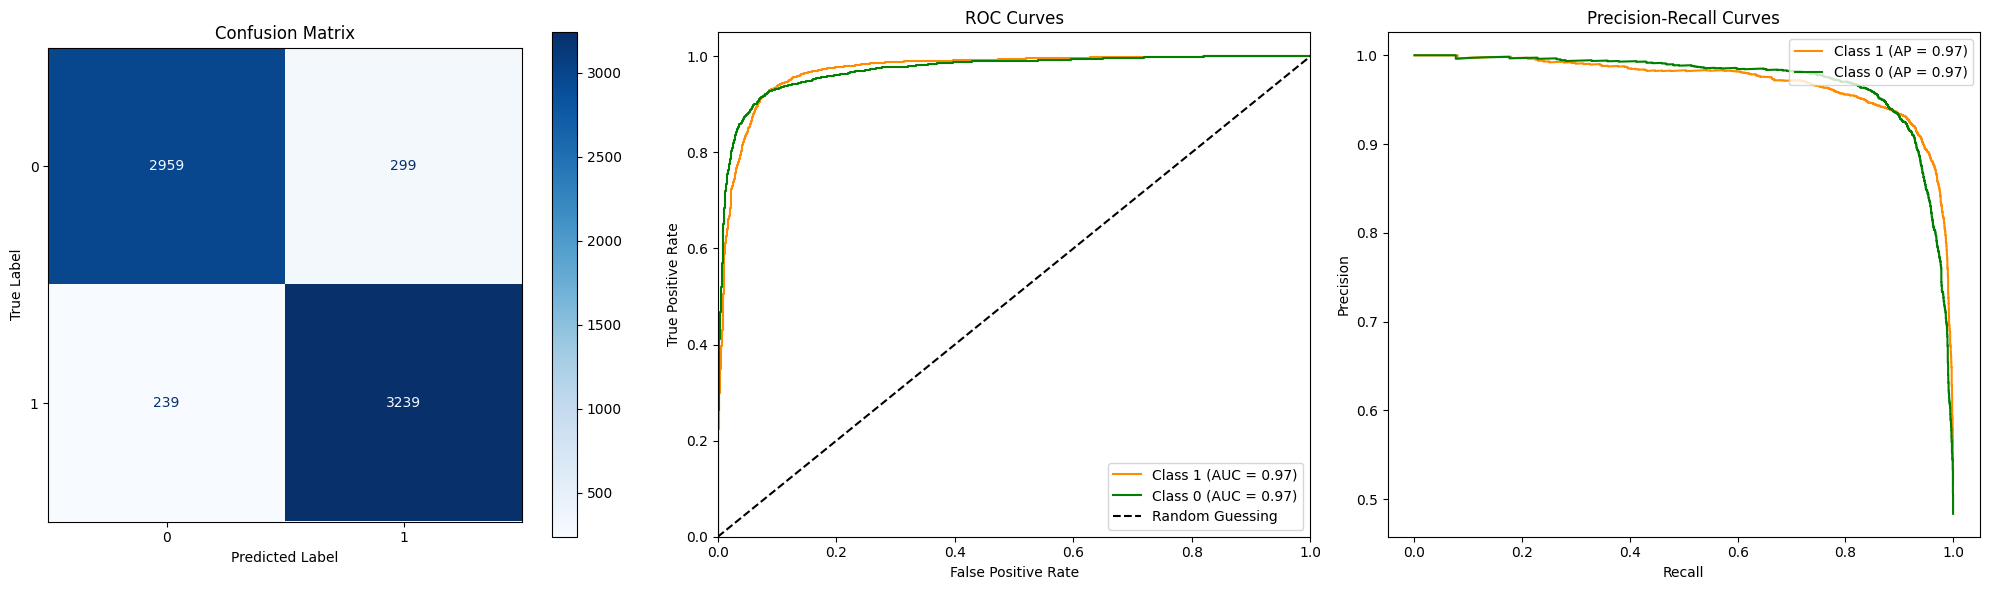

In [ ]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ---------------------------------
# Confusion Matrix
# ---------------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ---------------------------------
# ROC Curves
# ---------------------------------
# Get predicted probabilities for each class
y_probs_class1 = predictions.predictions[:, 1]
y_probs_class0 = predictions.predictions[:, 0]

# Compute ROC curve and AUC for class 1
fpr1, tpr1, _ = roc_curve(y_true, y_probs_class1, pos_label=1)
roc_auc1 = auc(fpr1, tpr1)

# Compute ROC curve and AUC for class 0
fpr0, tpr0, _ = roc_curve(y_true, y_probs_class0, pos_label=0)
roc_auc0 = auc(fpr0, tpr0)

# Plot ROC curves
axes[1].plot(fpr1, tpr1, label=f'Class 1 (AUC = {roc_auc1:.2f})', color='darkorange')
axes[1].plot(fpr0, tpr0, label=f'Class 0 (AUC = {roc_auc0:.2f})', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guessing')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend(loc="lower right")

# ---------------------------------
# Precision-Recall Curves
# ---------------------------------
# For Class 1
precision1, recall1, _ = precision_recall_curve(y_true, y_probs_class1, pos_label=1)
avg_precision1 = average_precision_score(y_true, y_probs_class1)

# For Class 0
y_true_inverted = np.where(y_true == 0, 1, 0)
precision0, recall0, _ = precision_recall_curve(y_true_inverted, y_probs_class0)
avg_precision0 = average_precision_score(y_true_inverted, y_probs_class0)

# Plot Precision-Recall curves
axes[2].plot(recall1, precision1, label=f'Class 1 (AP = {avg_precision1:.2f})', color='darkorange')
axes[2].plot(recall0, precision0, label=f'Class 0 (AP = {avg_precision0:.2f})', color='green')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curves')
axes[2].legend(loc="upper right")

# Display all plots in one row
plt.tight_layout()
plt.show()


# **Evaluation on Data Augmented Test Set**

### Create Augmented Data Set

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/nlu/dev.csv', sep=',', quotechar='"',
                 names=['premise', 'hypothesis', 'label'], header=None)

# If the first row is the header, remove it
if df.iloc[0, 0] == 'premise':
    df = df.iloc[1:]

# Make sure the label column is numeric
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

print("DataFrame loaded successfully:")
print(f"DataFrame shape: {df.shape}")
df.head()

DataFrame loaded successfully:
DataFrame shape: (6736, 3)


,premise,hypothesis,label
1,"By starting at the soft underbelly, the 16,000...","General Nelson A. Miles had 30,000 troops in h...",0
2,"The class had broken into a light sweat, but w...",The class grew more tense as time went on.,1
3,"Samson had his famous haircut here, but he wou...",It was unknown where exactly within the town S...,1
4,A man with a black shirt holds a baby while a ...,A darkly dressed man passes a crying baby to a...,0
5,I know that many of you are interested in addr...,The problems must be addressed,1


In [ ]:
# Function to replace words with synonyms
def replace_with_synonyms(text, replace_probability=0.25):
    text = str(text).strip('"')

    words = nltk.word_tokenize(text)
    new_words = []

    for word in words:
        # Skip short words, punctuation, and common words
        if len(word) <= 3 or not word.isalpha() or word.lower() in ['the', 'and', 'but', 'for', 'nor', 'or', 'yet', 'so']:
            new_words.append(word)
            continue

        # Only replace with the given probability
        if random.random() > replace_probability:
            new_words.append(word)
            continue

        # Find synonyms
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym.lower() != word.lower():
                    synonyms.append(synonym)

        if synonyms:
            new_words.append(random.choice(synonyms))
        else:
            new_words.append(word)

    # Reconstruct the text
    result = ' '.join(new_words)

    # Capitalize first letter of sentences
    result = '. '.join(s.strip().capitalize() for s in result.split('. '))

    return result

# Create a list to hold ONLY the augmented examples
augmented_rows = []

# Add augmented samples
for idx, row in df.iterrows():
    # Create 1-2 augmented versions for each sample
    for _ in range(random.randint(1, 2)):
        new_row = row.copy()

        # Determine what to augment
        change_premise = random.random() < 0.7
        change_hypothesis = random.random() < 0.7

        if change_premise:
            new_row['premise'] = replace_with_synonyms(new_row['premise'])

        if change_hypothesis:
            new_row['hypothesis'] = replace_with_synonyms(new_row['hypothesis'])

        # Only add if something was changed
        if (new_row['premise'] != row['premise'] or
            new_row['hypothesis'] != row['hypothesis']):
            augmented_rows.append(new_row)

augmented_df = pd.DataFrame(augmented_rows)
augmented_df.to_csv('/content/drive/MyDrive/nlu/augmented_test_set_evalC.csv', index=False,
                   quoting=csv.QUOTE_NONNUMERIC)

print(f"Original dataset: {len(df)} samples")
print(f"Created {len(augmented_df)} augmented samples")

# Show sample of augmented data
print("\nSample of augmented data:")
augmented_df.head()

Original dataset: 6736 samples
Created 9246 augmented samples

Sample of augmented data:


,premise,hypothesis,label
1,"By pop at the subdued underbody , the 16,000 s...","General admiral nelson a. Air mile had 30,000 ...",0
2,"The class had broken into a light sweat, but w...",The class grew more tense as time went on .,1
3,"Samson had his famous haircut here, but he wou...",It was unknown quantity where exactly within t...,1
4,A man with a black shirt hold a featherbed whi...,A in darkness dressed man passes a cry baby to...,0
4,A man with a black shirt holds a baby while a ...,A darkly lop man passes a crying baby to a man...,0


### Load Model to Make Predictions on the Augmented Dataset

In [ ]:
# Load the dataset and csv
dataset_df = pd.read_csv('/content/drive/MyDrive/nlu/augmented_test_set_evalC.csv')
dataset_df["label"] = dataset_df["label"].astype(int)

dataset_ds = Dataset.from_pandas(dataset_df).map(tokenize, batched=True).rename_column("label", "labels")
dataset_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# Make Predictions
eval_trainer = Trainer(model=model)
predictions = eval_trainer.predict(dataset_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

Map:   0%|          | 0/9246 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

### Classification Report on Augmented Dataset

In [ ]:
report_dict = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report_dict.pop('accuracy')
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns=['support'])
print("Overall Accuracy:")
print(overall_accuracy)
print("\nClassification Report:")
print(report_df)

Overall Accuracy:
0.8748643368786629

Classification Report:
              precision    recall  f1-score
0              0.876350  0.861111  0.868664
1              0.873535  0.887589  0.880506
macro avg      0.874943  0.874350  0.874585
weighted avg   0.874888  0.874864  0.874815
